In [156]:
from tensorflow.keras import datasets

# Load the train and test data for the MNIST dataset
(train_data, train_labels), (test_data, test_labels) = datasets.mnist.load_data()

# Normalize the value between [0, 1]
train_data, test_data = train_data/255.0, test_data/255.0

print('Train samples: ', len (train_data))
print('Test samples: ', len (test_data))

Train samples:  60000
Test samples:  10000


In [173]:
import numpy as np
print('Original shape: ', train_data.shape)
print('Transformed shape: ', np.array(list(map(gray2rgb, train_data))).shape)

Original shape:  (60000, 28, 28)
Transformed shape:  (60000, 28, 28, 3)


In [177]:
import numpy as np
from skimage.color import gray2rgb

# Turn the images into rgb, expected from LIME
train_data_rgb = np.array(list(map(gray2rgb, train_data))).astype(np.uint8)
test_data_rgb = np.array(list(map(gray2rgb, test_data))).astype(np.uint8)

Text(0.5, 1.0, 'Digit: 5')

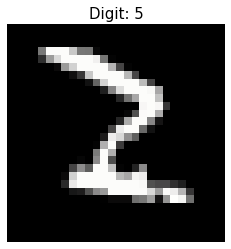

In [178]:
import matplotlib.pyplot as plt
import seaborn_image as isns

# Plot an example image and its label
isns.imshow(train_data[0], despine=True, cbar=False, cmap='gray')\
    .set_title('Digit: {}'.format(train_labels[0]))

In [179]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from skimage.color import rgb2gray
from sklearn.ensemble import RandomForestClassifier

# Create and fit the pipeline for the random forest classifier
classifier_pipeline = Pipeline([
    ('grayscale', FunctionTransformer(lambda imgs: [rgb2gray(img) for img in imgs])),
    ('flatten', FunctionTransformer(lambda imgs: [img.flatten() for img in imgs])),
    ('RF', RandomForestClassifier())
])

classifier_pipeline.fit(train_data_rgb, train_labels)

Pipeline(steps=[('grayscale',
                 FunctionTransformer(func=<function <lambda> at 0x1add529e0>)),
                ('flatten',
                 FunctionTransformer(func=<function <lambda> at 0x1adcff880>)),
                ('RF', RandomForestClassifier())])

Text(0.5, 1.0, 'Predicted: 0\nReal: 0')

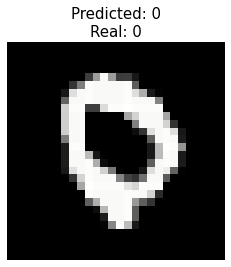

In [180]:
img_num = 3

# Use the pipeline to predict the label for an image
predictions = classifier_pipeline.predict(test_data_rgb[img_num:img_num+1])

isns.imshow(test_data[img_num], despine=True, cbar=False, cmap='gray')\
    .set_title('Predicted: {}\nReal: {}'.format(predictions[0], test_labels[img_num]))

In [162]:
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm

# Setup the LIME explainer
explainer = lime_image.LimeImageExplainer(verbose = False)
segmenter = SegmentationAlgorithm('quickshift', kernel_size=1, max_dist=200, ratio=0.2)

In [163]:
# Generate the explanation for an image
explanation = explainer.explain_instance(
    test_data_rgb[img_num],
    classifier_fn = classifier_pipeline.predict_proba,
    top_labels=10, hide_color=0, num_samples=10000, segmentation_fn=segmenter
)

  0%|          | 0/10000 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Positive/Negative Regions for 0')

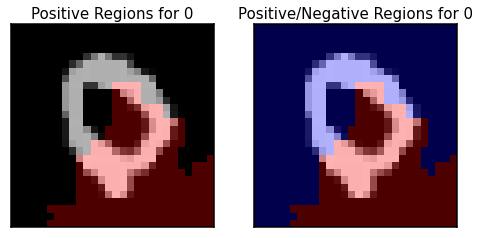

In [164]:
from skimage.color import label2rgb

# Plot the explanations for the prediction
img, mask = explanation.get_image_and_mask(
    test_labels[img_num],
    positive_only=True,
    num_features=10,
    hide_rest=False,
    min_weight=0.01)
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (8, 4))
isns.imshow(label2rgb(mask, test_data[img_num], bg_label = 0), interpolation = 'nearest', ax=ax1)
ax1.set_title('Positive Regions for {}'.format(test_labels[img_num]))

temp, mask = explanation.get_image_and_mask(
    test_labels[img_num],
    positive_only=False,
    num_features=10,
    hide_rest=False,
    min_weight = 0.01
)
isns.imshow(label2rgb(3-mask, test_data[img_num], bg_label = 0), interpolation = 'nearest', ax=ax2)
ax2.set_title('Positive/Negative Regions for {}'.format(test_labels[img_num]))